# Predictive Model A

This code is designed to identify whether a customer is a high-value or budget shopper and then predict whether they will respond to future marketing campaigns based on their past purchasing behavior and promotional engagement. The model does this by following the below steps:

1. Preprocessing the Data → Cleaning missing values, creating new features (Total_Spending,Marketing_Responsiveness), and encoding categorical data.

2. Classifying Customers as High-Value or Budget Shoppers → Based on their total spending, customers are assigned a category (Shopper_Type).

3. Predicting Marketing Response → Using machine learning models (Logistic Regression and Random Forest), the model predicts whether a customer will respond to a future marketing campaign.

The model also balances the dataset using SMOTE (Synthetic Minority Oversampling Technique) to ensure that the classification model is not biased toward customers who typically do not respond. The data is then split into training and testing sets (80% training, 20% testing), and the numerical features are normalized using StandardScaler() to ensure a fair comparison between different features.

# Step 1: Importing Required Libraries

* pandas, numpy → Handle tabular data and numerical operations.
* matplotlib.pyplot, seaborn → Used for visualization.
* train_test_split → Splits the dataset into training and testing sets.
* LogisticRegression, RandomForestClassifier → Machine learning models used for prediction.
accuracy_score, classification_report, confusion_matrix → Evaluate model performance.
* OneHotEncoder → Converts categorical variables into numeric format.
* StandardScaler → Standardizes numerical features for fair comparison.
* SMOTE → Handles class imbalance by oversampling the minority class.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

# Step 2: Load the dataset

In [2]:
url = "https://docs.google.com/spreadsheets/d/1ew-NKCxOwbRhSY2lIeO-XnxIb5tZrNCilixxu6y8ZnM/export?format=csv"
df = pd.read_csv(url)

# Step 3: Display the First 5 Rows to Make Sure the Dataset Exists

In [3]:
df.head(5)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


# Step 4: Handle Missing Values

Fills missing values in the Income column with the median value to prevent errors during training.

The median is used instead of the mean because it is less affected by outliers.

In [4]:
df["Income"].fillna(df["Income"].median(), inplace=True)

<ipython-input-4-2e8901f458b5>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Income"].fillna(df["Income"].median(), inplace=True)


# Step 5: Create the Total_Spending Feature

Sums up spending on different product categories.

Helps classify customers into high-value vs. budget shoppers.

In [5]:
df["Total_Spending"] = (
    df["MntWines"] + df["MntFruits"] + df["MntMeatProducts"] +
    df["MntFishProducts"] + df["MntSweetProducts"] + df["MntGoldProds"]
)

# Step 6: Create the Marketing_Responsiveness Feature

Counts the number of marketing campaigns a customer has accepted.

Higher values mean higher engagement with promotions.

In [6]:
df["Marketing_Responsiveness"] = (
    df["AcceptedCmp1"] + df["AcceptedCmp2"] + df["AcceptedCmp3"] +
    df["AcceptedCmp4"] + df["AcceptedCmp5"] + df["Response"]
)

# Step 7: Categorize Customers into High-Value vs. Budget Shoppers

Classifies customers into two groups:
* "High Value" (spending above the median).
* "Budget" (spending below the median).

In [7]:
median_spending = df["Total_Spending"].median()
df["Shopper_Type"] = np.where(df["Total_Spending"] >= median_spending, "High Value", "Budget")

# Step 8: One-Hot Encoding for Categorical Features

Converts categorical variables (Education, Marital_Status, Shopper_Type) into numerical form for machine learning.

Removes the original categorical columns and replaces them with their encoded versions.

In [8]:
encoder = OneHotEncoder(drop="first", sparse_output=False)
encoded_cats = encoder.fit_transform(df[["Education", "Marital_Status", "Shopper_Type"]])
encoded_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out())

df = pd.concat([df.drop(columns=["Education", "Marital_Status", "Shopper_Type"]), encoded_df], axis=1)

# Step 9: Define Features (X) and Target (y)

Features (X) → All columns except ID, Response, and Dt_Customer (not useful for prediction).

Target (y) → The Response column, which indicates whether a customer will respond to future campaigns.

In [9]:
X = df.drop(columns=["ID", "Response", "Dt_Customer"])
y = df["Response"]

# Step 10: Balance the Dataset Using SMOTE

Balances the dataset by oversampling the minority class (responders).

Prevents the model from being biased toward non-responders.

In [10]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Step 11: Split Data into Training & Testing Sets

Splits the balanced data into 80% training and 20% testing sets.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)


# Step 12: Standardize Features

Normalizes numerical features to ensure fair comparisons.

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 13: Train the Models

Trains two models → Logistic Regression & Random Forest.

In [13]:
log_reg_model = LogisticRegression(max_iter=1000, random_state=42)
log_reg_model.fit(X_train, y_train)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# Step 14: Make Predictions

Uses the trained models to predict customer responses on test data.

In [14]:
y_pred_logreg = log_reg_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Step 15: Evaluate Model Performance

Computes accuracy, precision, recall, and F1-score for each model.

In [15]:
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
classification_report_logreg = classification_report(y_test, y_pred_logreg)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
classification_report_rf = classification_report(y_test, y_pred_rf)

# Step 16: Compute & Visualize Confusion Matrix

----- Results: Logistic Regression -------------------------------------
Logistic Regression Accuracy: 0.9987

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       382
           1       1.00      1.00      1.00       381

    accuracy                           1.00       763
   macro avg       1.00      1.00      1.00       763
weighted avg       1.00      1.00      1.00       763

----- Results: Random Forest ------------------------------------------
Random Forest Accuracy: 0.9777

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.98       382
           1       0.96      0.99      0.98       381

    accuracy                           0.98       763
   macro avg       0.98      0.98      0.98       763
weighted avg       0.98      0.98      0.98       763



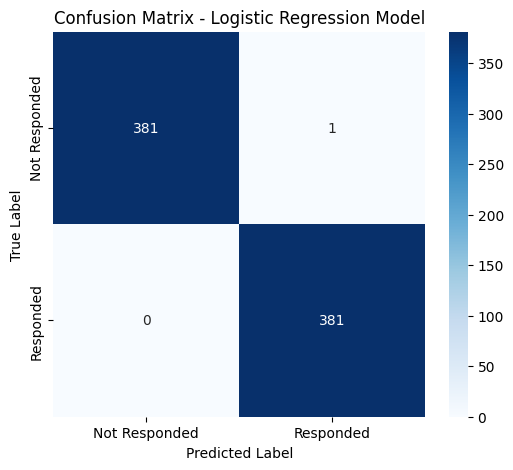

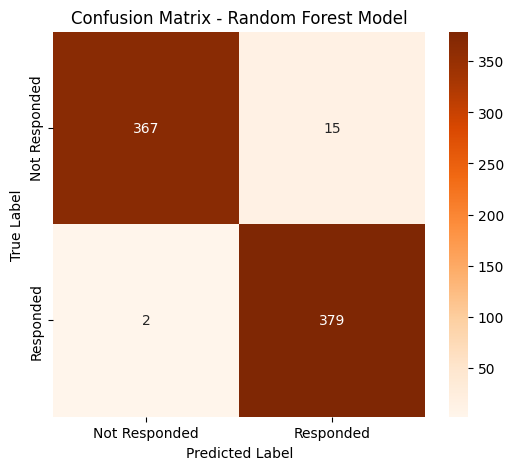

<ipython-input-16-0972bdb35be0>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances_logreg[:10], y=feature_importances_logreg.index[:10], palette="viridis")


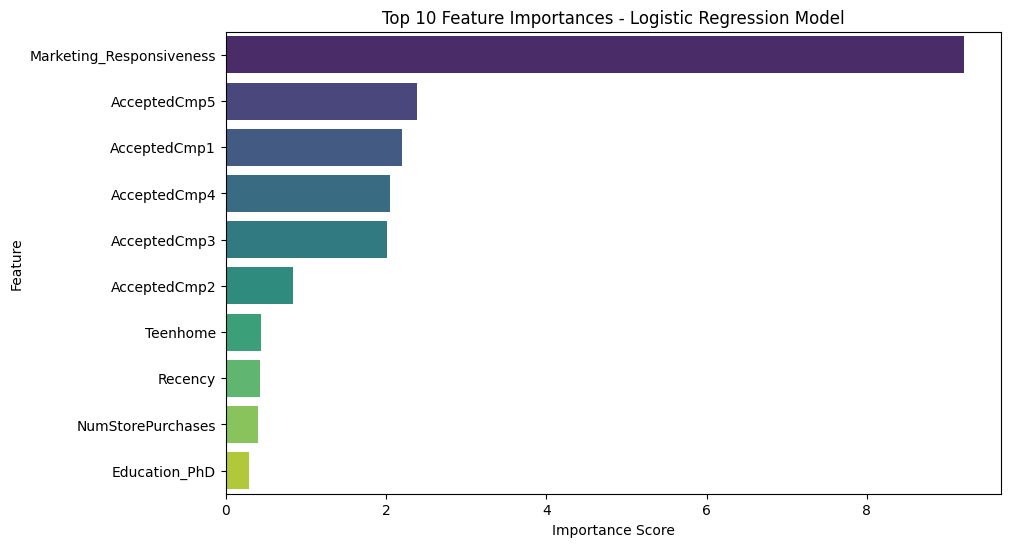

<ipython-input-16-0972bdb35be0>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances_rf[:10], y=feature_importances_rf.index[:10], palette="coolwarm")


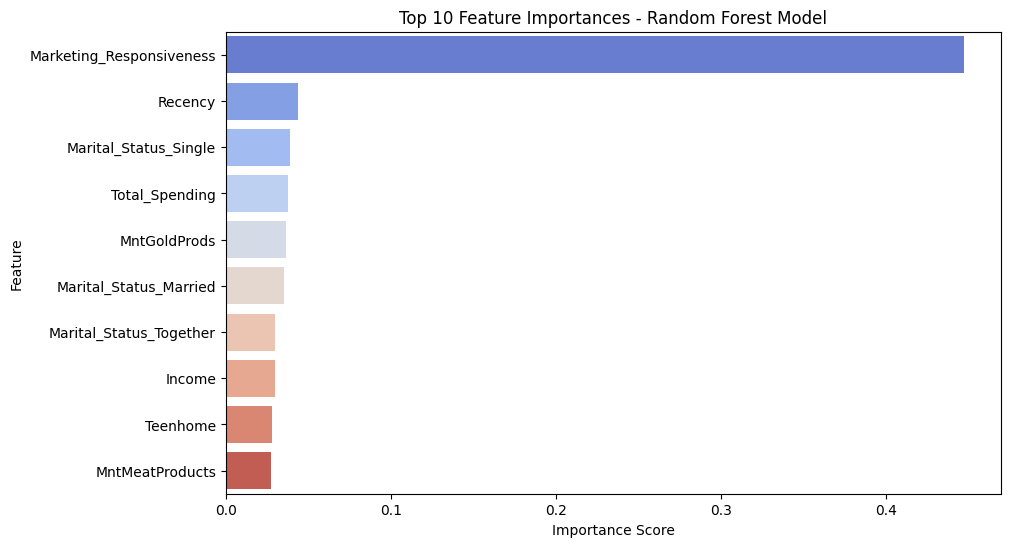

In [16]:
# Display Results.
print("----- Results: Logistic Regression -------------------------------------")
print(f"Logistic Regression Accuracy: {accuracy_logreg:.4f}")
print("\nClassification Report:\n", classification_report_logreg)

print("----- Results: Random Forest ------------------------------------------")
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
print("\nClassification Report:\n", classification_report_rf)

# Compute confusion matrix for Logistic Regression.
cm_logreg = confusion_matrix(y_test, y_pred_logreg)

# Plot Confusion Matrix.
plt.figure(figsize=(6, 5))
sns.heatmap(cm_logreg, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Responded", "Responded"], yticklabels=["Not Responded", "Responded"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Logistic Regression Model")
plt.show()

# Compute confusion matrix for Random Forest.
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Oranges", xticklabels=["Not Responded", "Responded"], yticklabels=["Not Responded", "Responded"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest Model")
plt.show()

# Feature Importance (Using Absolute Coefficients for Logistic Regression).
feature_importances_logreg = pd.Series(abs(log_reg_model.coef_.flatten()), index=X.columns)
feature_importances_logreg = feature_importances_logreg.sort_values(ascending=False)

# Plot Feature Importance.
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_logreg[:10], y=feature_importances_logreg.index[:10], palette="viridis")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importances - Logistic Regression Model")
plt.show()

# Feature Importance (Using Feature Importances from Random Forest).
feature_importances_rf = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances_rf = feature_importances_rf.sort_values(ascending=False)

# Plot Feature Importance for Random Forest.
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_rf[:10], y=feature_importances_rf.index[:10], palette="coolwarm")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importances - Random Forest Model")
plt.show()

# Conclusion

The Logistic Regression model has an accuracy of 99.87%, meaning it correctly predicts customer responses to marketing campaigns almost perfectly.

The Random Forest model achieved an accuracy of 97.77%, which indicates that it performs very well in predicting customer responses to marketing campaigns.

# Retrospective: The Below is the Entire Code

<ipython-input-17-41947439d10a>:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Income"].fillna(df["Income"].median(), inplace=True)


----- Results: Logistic Regression -------------------------------------
Logistic Regression Accuracy: 0.9987

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       382
           1       1.00      1.00      1.00       381

    accuracy                           1.00       763
   macro avg       1.00      1.00      1.00       763
weighted avg       1.00      1.00      1.00       763

----- Results: Random Forest ------------------------------------------
Random Forest Accuracy: 0.9777

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.98       382
           1       0.96      0.99      0.98       381

    accuracy                           0.98       763
   macro avg       0.98      0.98      0.98       763
weighted avg       0.98      0.98      0.98       763



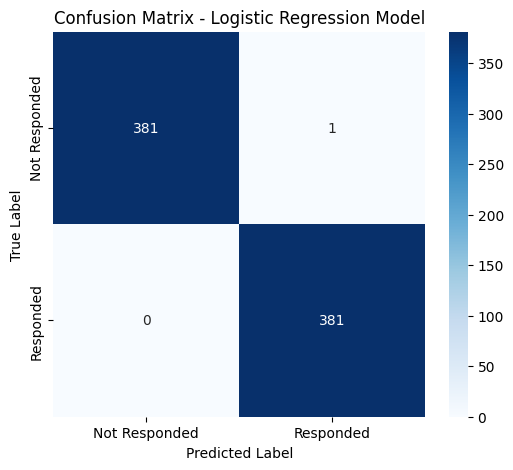

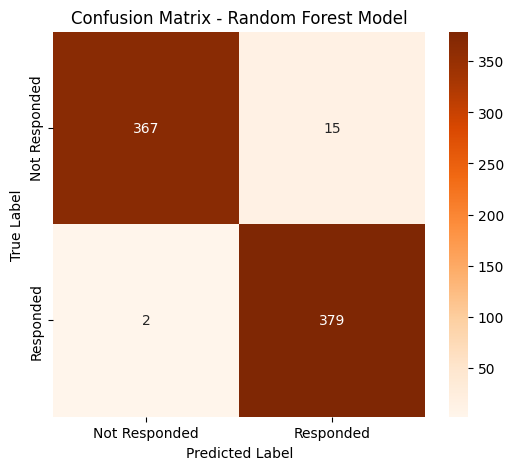

<ipython-input-17-41947439d10a>:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances_logreg[:10], y=feature_importances_logreg.index[:10], palette="viridis")


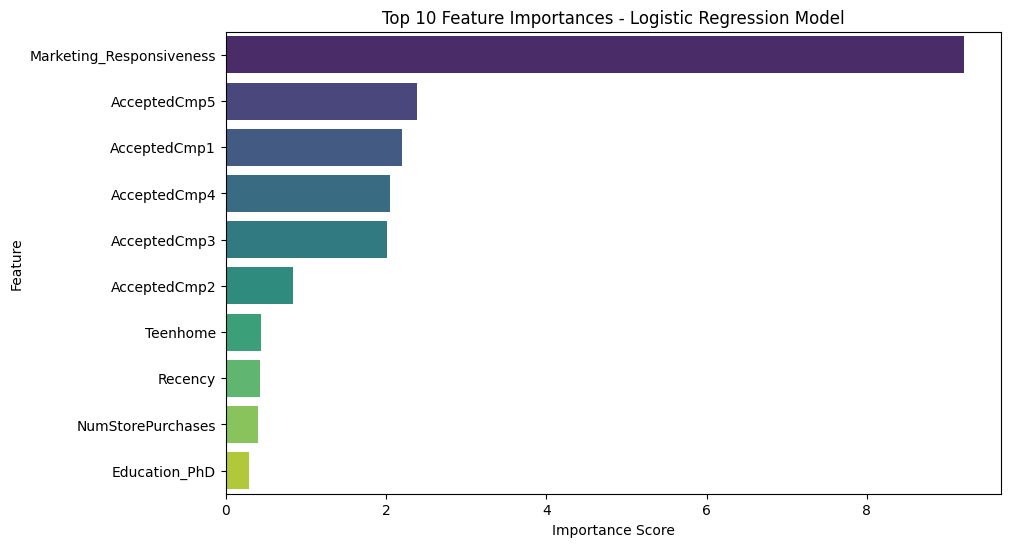

<ipython-input-17-41947439d10a>:132: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances_rf[:10], y=feature_importances_rf.index[:10], palette="coolwarm")


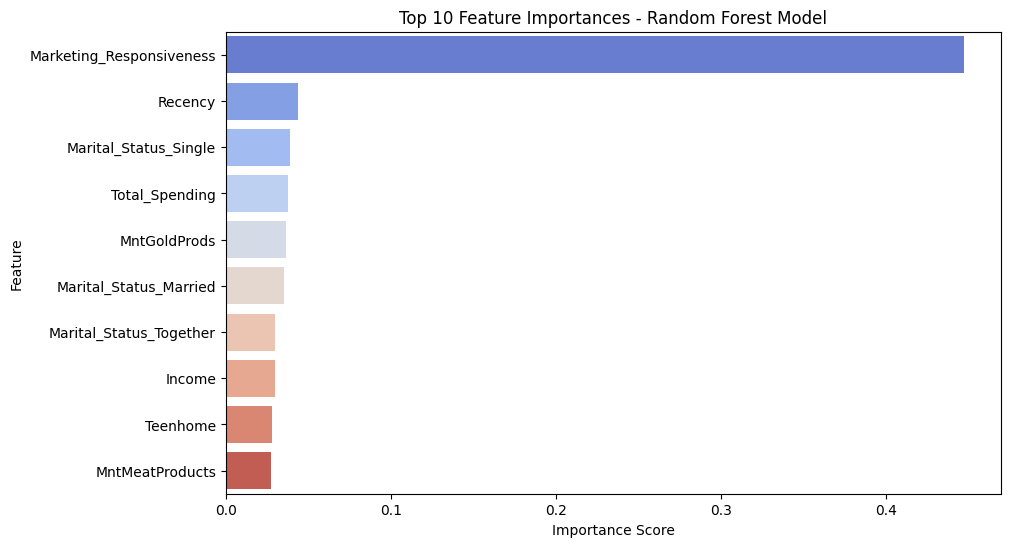

In [17]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

# Load dataset
url = "https://docs.google.com/spreadsheets/d/1ew-NKCxOwbRhSY2lIeO-XnxIb5tZrNCilixxu6y8ZnM/export?format=csv"
df = pd.read_csv(url)

# Display first few rows.
df.head(5)

# Fill missing values in 'Income' column with median.
df["Income"].fillna(df["Income"].median(), inplace=True)

# Create "Total_Spending" feature to sum spending over the last 2 years.
df["Total_Spending"] = (
    df["MntWines"] + df["MntFruits"] + df["MntMeatProducts"] +
    df["MntFishProducts"] + df["MntSweetProducts"] + df["MntGoldProds"]
)

# Create "Marketing_Responsiveness" score to measure past engagement with promotions.
df["Marketing_Responsiveness"] = (
    df["AcceptedCmp1"] + df["AcceptedCmp2"] + df["AcceptedCmp3"] +
    df["AcceptedCmp4"] + df["AcceptedCmp5"] + df["Response"]
)

# Categorize customers into 'High Value' or 'Budget' shoppers based on Total Spending.
median_spending = df["Total_Spending"].median()
df["Shopper_Type"] = np.where(df["Total_Spending"] >= median_spending, "High Value", "Budget")

# One-Hot Encoding for categorical features ('Education', 'Marital_Status', 'Shopper_Type').
encoder = OneHotEncoder(drop="first", sparse_output=False)
encoded_cats = encoder.fit_transform(df[["Education", "Marital_Status", "Shopper_Type"]])
encoded_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out())

# Merge encoded features into dataframe & drop original categorical columns.
df = pd.concat([df.drop(columns=["Education", "Marital_Status", "Shopper_Type"]), encoded_df], axis=1)

# Define Features (X) and Target (y).
X = df.drop(columns=["ID", "Response", "Dt_Customer"])  # Exclude non-relevant columns
y = df["Response"]  # Target variable

# Balance the dataset using SMOTE (Synthetic Minority Oversampling).
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split data into Training (80%) and Testing (20%) sets.
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Normalize numerical features using StandardScaler.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train Logistic Regression model.
log_reg_model = LogisticRegression(max_iter=1000, random_state=42)
log_reg_model.fit(X_train, y_train)

# Train Random Forest model for comparison.
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions.
y_pred_logreg = log_reg_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Evaluate Logistic Regression model.
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
classification_report_logreg = classification_report(y_test, y_pred_logreg)

# Evaluate Random Forest model.
accuracy_rf = accuracy_score(y_test, y_pred_rf)
classification_report_rf = classification_report(y_test, y_pred_rf)

# Display Results.
print("----- Results: Logistic Regression -------------------------------------")
print(f"Logistic Regression Accuracy: {accuracy_logreg:.4f}")
print("\nClassification Report:\n", classification_report_logreg)

print("----- Results: Random Forest ------------------------------------------")
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
print("\nClassification Report:\n", classification_report_rf)

# Compute confusion matrix for Logistic Regression.
cm_logreg = confusion_matrix(y_test, y_pred_logreg)

# Plot Confusion Matrix.
plt.figure(figsize=(6, 5))
sns.heatmap(cm_logreg, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Responded", "Responded"], yticklabels=["Not Responded", "Responded"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Logistic Regression Model")
plt.show()

# Compute confusion matrix for Random Forest.
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Oranges", xticklabels=["Not Responded", "Responded"], yticklabels=["Not Responded", "Responded"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest Model")
plt.show()

# Feature Importance (Using Absolute Coefficients for Logistic Regression).
feature_importances_logreg = pd.Series(abs(log_reg_model.coef_.flatten()), index=X.columns)
feature_importances_logreg = feature_importances_logreg.sort_values(ascending=False)

# Plot Feature Importance.
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_logreg[:10], y=feature_importances_logreg.index[:10], palette="viridis")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importances - Logistic Regression Model")
plt.show()

# Feature Importance (Using Feature Importances from Random Forest).
feature_importances_rf = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances_rf = feature_importances_rf.sort_values(ascending=False)

# Plot Feature Importance for Random Forest.
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_rf[:10], y=feature_importances_rf.index[:10], palette="coolwarm")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importances - Random Forest Model")
plt.show()
